## EC3364 Final Project - 2402237

## Task 0

#### Uploaded from GitHub (to not use local file path) as I could not connect my virtual environment to Jupyter nor use Kiwix. Sorry!

### Instructions to run the the spider:


1) Navigate to the 'final_project' folder in the zip file
2) Open the 'security_exchange' folder located inside (press twice)
3) Navigate to the 'spiders' folder
4) Open the project_se.py folder
5) After loading into the correct wd/virtual environment, run the spider using the following command:

scrapy crawl stackexchange -o final_output.json

Now the spider should crawl and scrape all the data

#### Standard Imports

In [112]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.dates as mdates
import statsmodels.api as sm

## Import Data

In [113]:
# Path to the JSON file
json_path = 'https://raw.githubusercontent.com/tarick-akpan/EC3364-Final-Project/main/final_output.json'

# Read the JSON file into a DataFrame
reed = pd.read_json(json_path)

# Function to normalize question_id
def normalize_question_id(row):
    if 'title' in row and pd.notna(row['title']):
        return row['question_id']
    else:
        return row['associated_question_id'] if 'associated_question_id' in row else None

# Apply the function to normalize question_id
reed['question_id'] = reed.apply(normalize_question_id, axis=1)

# Drop the 'associated_question_id' column if it exists
if 'associated_question_id' in reed.columns:
    reed.drop(columns='associated_question_id', inplace=True)

# Sort question_id
sorted_reed = reed.sort_values(by='question_id', ascending=False)
reed


,question_id,title,posting_date,tags,user_id_asker,asker_reputation,total_questions_posted_byuser,total_answers_posted_byuser,total_comments_posted_byuser,answer_id,user_id_answerer,answerer_reputation,comment_id,associated_post_id,user_id_commenter,commenter_reputation
0,274149.0,Is it a security risk to put MAC-adresses in a...,2024-01-17 19:23:29Z,"[tls, certificates, mac-address, csr, tls, cer...",denisred,1.0,1,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,274068.0,How To Decrypt .Cdtt Ransomware Files [closed],2024-01-12 08:18:50Z,"[malware, virus, ransomware, malware, virus, r...",schroeder,128689.0,17,1968.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,274078.0,NaN,2024-01-13 07:16:11Z,NaN,NaN,NaN,1,571.0,20.0,274080.0,mti2935,22819.0,NaN,NaN,NaN,NaN
3,274079.0,Would this be EPA or AES? [closed],2024-01-13 10:42:48Z,"[aes, wireless, authorization, confidentiality...",dipsew,1.0,1,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,274082.0,NaN,2024-01-13 15:17:32Z,NaN,NaN,NaN,0,123.0,192.0,274083.0,gh0stfish,9377.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,267023.0,Clarification on vulnerability statuses,2022-12-13 09:26:44Z,"[ubuntu, cve, debian, ubuntu, cve, debian]",onaonoamemeamet,1.0,1,0.0,518.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1622,267022.0,Is running PHP file_get_contents on random use...,2022-12-13 08:52:50Z,"[php, webserver, server, php, webserver, server]",syed-m-sannan,296.0,3,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623,267026.0,What is the attack surface of CVE-2014-3802?,2022-12-13 10:08:06Z,"[cve, cve]",motti,111.0,1,0.0,146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1624,267025.0,"Are there any security reasons against ""drop-w...",2022-12-13 09:59:57Z,"[cookies, domain, sub-domain, cookies, domain,...",adrelanos,754.0,17,2.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Task one

#### Part 1

In [114]:
def tag_frequencies(df, tags_list):
    # Extract all tags from the DataFrame
    all_tags = [tag for sublist in df['tags'].dropna() for tag in sublist]

    # Count the frequency of each tag
    tag_counts = Counter(all_tags)

    # Filter the counts for the specified tags
    filtered_counts = {tag: tag_counts[tag] for tag in tags_list}

    # Create a bar chart for the tag frequencies
    plt.figure(figsize=(10, 6))
    plt.bar(filtered_counts.keys(), filtered_counts.values())
    plt.xlabel('Tags')
    plt.ylabel('Frequency')
    plt.title('Frequency of Specified Tags in the Subforum')
    plt.xticks(rotation=45)
    plt.show()

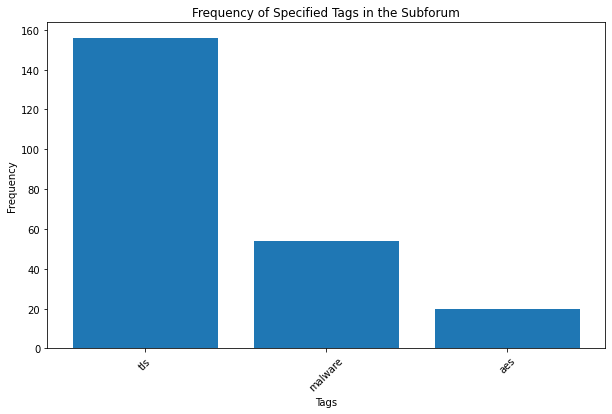

In [115]:
# Example usage:
tag_frequencies(reed, ['tls', 'malware', 'aes'])

#### Part 2

In [116]:
def plot_top_tags_over_time(reed, top_n=5):
    # Flatten the list of tags and count occurrences
    all_tags = [tag for sublist in reed['tags'].dropna() for tag in sublist]
    tag_counts = Counter(all_tags)

    # Get the top N most common tags
    top_tags = [tag for tag, count in tag_counts.most_common(top_n)]

    # Convert 'posting_date' to datetime and normalize to either tz-aware or tz-naive
    reed['posting_date'] = pd.to_datetime(reed['posting_date'], utc=True)

    # Set up the plot
    plt.figure(figsize=(15, 7))

    for tag in top_tags:
        # Filter DataFrame for each tag
        tag_df = reed[reed['tags'].apply(lambda x: tag in x if isinstance(x, list) else False)]

        # Group by time interval (e.g., monthly) and count questions
        grouped = tag_df.groupby(pd.Grouper(key='posting_date', freq='M')).count()

        # Plot the data
        plt.plot(grouped.index, grouped['question_id'], label=tag)

    # Formatting the plot
    plt.xlabel('Time')
    plt.ylabel('Number of Questions')
    plt.title('Number of Questions Over Time for Top 5 Tags')
    plt.legend()

    # Adjust x-axis to only show each year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
    plt.show()

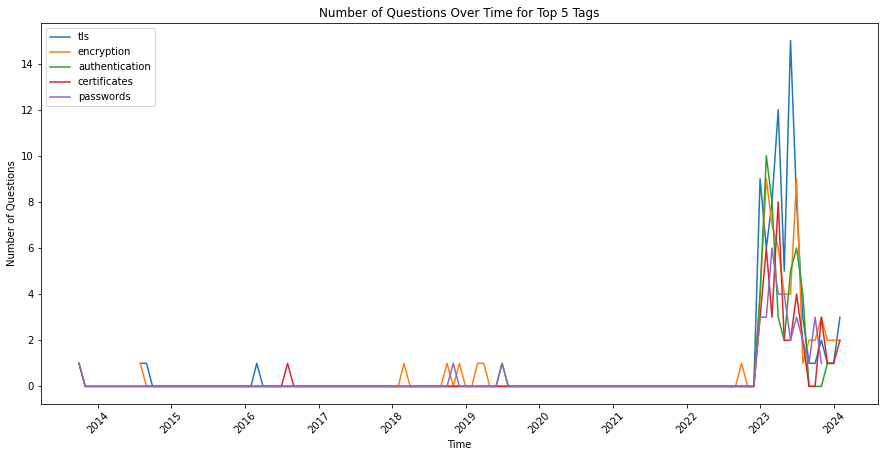

In [117]:
# Example usage
plot_top_tags_over_time(reed)

#### Part 3

In [118]:
def find_most_active_user(df, tag, activity_type):
    # Filter for the specific tag if not "all"
    if tag != "all":
        df = df[df['tags'].apply(lambda x: tag in x if isinstance(x, list) else False)]
    
    # Initialize the most active user variable
    most_active = None
    
    # Depending on the type, perform the appropriate aggregation
    if activity_type == "question":
        # Count the number of questions asked by each user and find the max
        user_counts = df.groupby('user_id_asker')['question_id'].count()
        most_active = user_counts.idxmax() if not user_counts.empty else None
    elif activity_type == "answer":
        # Count the number of answers given by each user and find the max
        user_counts = df.groupby('user_id_answerer')['answer_id'].count()
        most_active = user_counts.idxmax() if not user_counts.empty else None
    elif activity_type == "comment":
        # Count the number of comments made by each user and find the max
        user_counts = df.groupby('user_id_commenter')['comment_id'].count()
        most_active = user_counts.idxmax() if not user_counts.empty else None
    else:
        raise ValueError("Type must be 'question', 'answer', or 'comment'")
    
    return most_active if most_active else "No users with the specified criteria."

In [119]:
# Example usage:
find_most_active_user(reed, "tls", "question")

'assistanttotheca'

#### Part 4

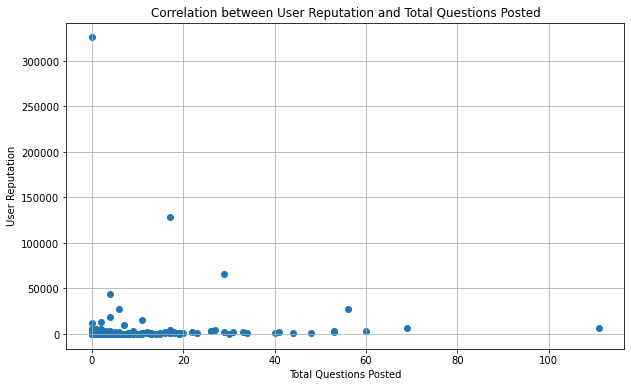

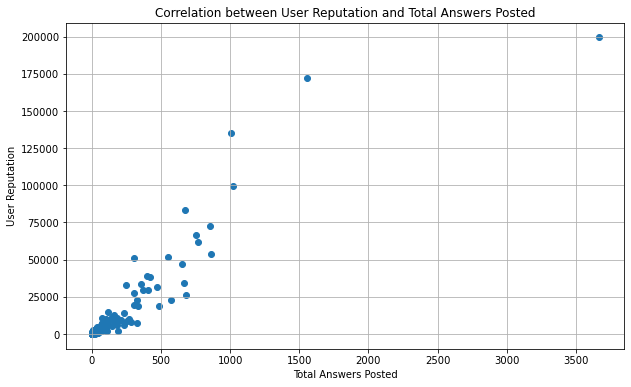

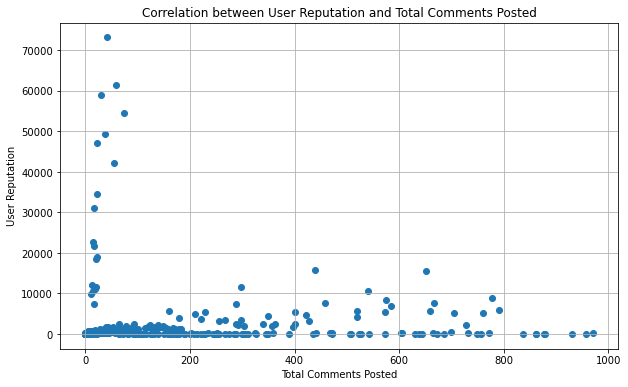

In [120]:
def plot_user_activity(df):
    # Plot for Questions vs Reputation
    plt.figure(figsize=(10, 6))
    plt.scatter(df['total_questions_posted_byuser'], df['asker_reputation'])
    plt.xlabel("Total Questions Posted")
    plt.ylabel("User Reputation")
    plt.title("Correlation between User Reputation and Total Questions Posted")
    plt.grid(True)
    plt.show()

    # Plot for Answers vs Reputation
    plt.figure(figsize=(10, 6))
    plt.scatter(df['total_answers_posted_byuser'], df['answerer_reputation'])
    plt.xlabel("Total Answers Posted")
    plt.ylabel("User Reputation")
    plt.title("Correlation between User Reputation and Total Answers Posted")
    plt.grid(True)
    plt.show()

    # Plot for Comments vs Reputation
    plt.figure(figsize=(10, 6))
    plt.scatter(df['total_comments_posted_byuser'], df['commenter_reputation'])
    plt.xlabel("Total Comments Posted")
    plt.ylabel("User Reputation")
    plt.title("Correlation between User Reputation and Total Comments Posted")
    plt.grid(True)
    plt.show()

# Call the function with your DataFrame
plot_user_activity(reed)

The "Answers vs Reputation" graph is most insightful in illustrating the relationship between the activity of users on the stackexchange and their reputation. This graph displays a positive trend indicating that users who have contributed a larger number of answers tend to have higher reputations. This pattern suggests a strong and positive correlation between these two variables – the number of answers posted and the reputation of the users.

Several key observations support this conclusion:

Strong Positive Correlation: The graph shows that as the number of answers increases, so does the user's reputation. This trend is more linear and consistent compared to the other graphs (such as "Questions vs Reputation" and "Comments vs Reputation"), indicating a stronger correlation. The linear pattern is a classic indication of a positive correlation, where an increase in one variable is associated with an increase in another.

Density of Data Points: The concentration of data points along the upward trajectory on the graph signifies that this pattern is consistent across a broad spectrum of users, not just limited to a few outliers. This density provides confidence that the observed trend is representative of the general user behavior on the platform.

Fewer Outliers: Compared to the other graphs, the "Answers vs Reputation" graph has fewer outliers. Outliers can often skew the perception of a relationship between variables. The relative lack of outliers in this graph suggests that the observed correlation is not significantly impacted by extreme values, thereby lending greater validity to the observed trend.

#### Part 5

In [121]:
# We will use 'total_answers_posted_byuser' as the independent variable (X) and 'answerer_reputation' as the dependent variable (Y)
X = reed['total_answers_posted_byuser'].fillna(0) 
Y = reed['answerer_reputation'].fillna(0)  

# We will add a constant term to the independent variable we do not capture all variables
X = sm.add_constant(X)

# Run the OLS regression
model = sm.OLS(Y, X).fit()

# Print the summary of the regression
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     answerer_reputation   R-squared:                       0.532
Model:                             OLS   Adj. R-squared:                  0.532
Method:                  Least Squares   F-statistic:                     1847.
Date:                 Thu, 18 Jan 2024   Prob (F-statistic):          3.82e-270
Time:                         01:23:25   Log-Likelihood:                -16553.
No. Observations:                 1626   AIC:                         3.311e+04
Df Residuals:                     1624   BIC:                         3.312e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const   

#### Interpretation of Results

When examining the OLS regression results for the connection between the number of answers users have contributed and their reputation scores, we uncover some intriguing insights;

R-squared at 0.532: This figure tells us that 53.2% of the variation in reputation scores among users is tied to how many answers they've posted. Whilst it is a significant chunk, but it also hints that other factors are playing a role in shaping reputation that we're not accounting for in this analysis.

The Coefficients Breakdown:

The Constant ( -68.7593 ): This is a baseline reputation when no answers are posted. The figure here is around  -68.76, but the high p-value suggests we shouldn't put too much stock in this specific number.
Total Answers Posted (43.1424): For every additional answer a user posts, their reputation is likely to increase by about 43.14 points. This is a significant finding, backed by a very low p-value.
P-value (Extremely Low): The minuscule p-value here strongly suggests that this pattern we're seeing isn't just a fluke or a random occurrence. There's a real relationship here.

Durbin-Watson Close to 2.0: This score supports our analysis. It implies that the residuals (the differences between observed and predicted values) aren't really following any discernible pattern that could skew our results.

Normality Tests (Omnibus, JB, Skew, Kurtosis): These tests suggest that the residuals – the differences between our model's predictions and the actual data – aren't evenly spread out. Our model isn't capturing all the nuances of the real-world data.

In summary, while our analysis does reveal a significant and positive link between the number of answers posted and reputation, it's crucial to remember that this doesn't necessarily mean one causes the other. There could be other factors at play that we haven't considered. Additionally, the concerns raised by the normality tests suggest that a more sophisticated model might give us a clearer picture of what's really going on. 

We can conclude, however, that our previous assertion is supported by these findings.